In [141]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import aic, bic
from sklearn.metrics import r2_score
import patsy
import matplotlib.pyplot as plt

In [142]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler

def find_num_components_explaining_90variance(data):
    """
    This function performs a PCA and finds the number of components that
    explain 90 %, 95 % and 99 % of the variance in the data.
    """
    fpca = PCA()
    fpca.fit(data)

    # Get the cumulative explained variance (in %)
    var_cumu = np.cumsum(fpca.explained_variance_ratio_) * 100

    # Percent-variance thresholds we care about
    percent_var = [80, 85, 90, 95, 99]

    for var in percent_var:
        k_all = np.argmax(var_cumu > var)
        print(f"No. of components explaining {var} % of the variance in data: {k_all}")
    #end function find_num_components_explaining_90variance

# empty room

In [143]:
df_90 = pd.read_csv(r'D:\vr-pipeline\data\results\28052025_segment_data_t123_90s_1s_ketone.csv')
#df_45= pd.read_csv(r'D:\vr-pipeline\data\results\22052025_segment_data_t123_45s_45s_ketone.csv')
df_30 = pd.read_csv(r'D:\vr-pipeline\data\results\28052025_segment_data_t123_30s_30s_ketone.csv')


df_all = pd.concat([df_90, df_30], ignore_index=True)

In [144]:
df_90

,participant_id,session,trial,version,segment,center_dist,edge_dist,speed,acceleration,stops_count,...,max_distance,area_covered,rmssd,hr,safe_area_coverage,unsafe_area_coverage,safe_time_spent,unsafe_time_spent,outside_time_spent,drink
0,EK_207,1,7,2,0,1.786122,0.682355,0.301608,9.471821,7,...,5.705291,13.269174,38.819143,64.775962,NaN,NaN,NaN,NaN,NaN,ketone
1,EK_207,1,11,2,0,1.722617,0.444282,0.217711,1.384794,7,...,5.654979,0.896033,36.606377,67.905104,24.451637,27.748409,27.6877,58.5320,4.7784,ketone
2,EK_207,1,15,2,0,3.798371,0.989149,0.227798,5.462296,17,...,5.919727,10.546768,38.819143,64.775962,NaN,NaN,NaN,NaN,NaN,ketone
3,EK_207,2,7,1,0,2.063429,0.536975,0.299718,7.567392,10,...,6.924042,13.166762,24.716223,77.029738,NaN,NaN,NaN,NaN,NaN,placebo
4,EK_207,2,11,1,0,2.120893,0.213506,0.216673,1.415689,6,...,5.581503,4.037973,23.138884,76.467968,8.689104,44.013514,7.0527,46.0733,37.8536,placebo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,EK_945,1,11,2,0,1.676581,0.377798,0.292413,-0.116480,6,...,4.797263,0.142525,36.015771,76.534542,15.590992,47.654816,13.3617,77.6229,0.0000,placebo
110,EK_945,1,15,2,0,3.635059,0.841491,0.294401,0.136262,4,...,6.707856,15.163907,41.753906,73.312517,NaN,NaN,NaN,NaN,NaN,placebo
111,EK_945,2,7,1,0,1.924872,0.664727,0.448783,0.343595,2,...,6.209382,23.567586,35.351652,72.630717,NaN,NaN,NaN,NaN,NaN,ketone
112,EK_945,2,11,1,0,1.784681,0.354312,0.287668,-0.087719,6,...,5.155403,0.468740,31.980787,74.458388,18.775269,44.601332,15.9250,74.5560,0.5090,ketone


In [145]:
df_90_empty_room=df_90[df_90['trial'] == 7]
#display(df_90)
df_90_pca = df_90_empty_room.drop(columns=['participant_id', 'edge_dist','drink', 'session','trial', 'version', 'segment', 'stops_count','unsafe_area_coverage', 'safe_area_coverage', 'safe_time_spent', 'unsafe_time_spent','outside_time_spent'])

#display(df_90_pca.head())

df_90_pca_x_axis= df_90_empty_room[['drink','session']]
df_90_pca_x_axis.loc[df_90_pca_x_axis['drink'] == 'placebo', 'drink'] = -0.5
df_90_pca_x_axis.loc[df_90_pca_x_axis['drink'] == 'ketone', 'drink'] = 0.5
scaler=StandardScaler()
df_90_pca_scaled=scaler.fit_transform(df_90_pca)
find_num_components_explaining_90variance(df_90_pca_scaled)

No. of components explaining 80 % of the variance in data: 3
No. of components explaining 85 % of the variance in data: 3
No. of components explaining 90 % of the variance in data: 4
No. of components explaining 95 % of the variance in data: 5
No. of components explaining 99 % of the variance in data: 6


In [146]:
def reduce_data(ratings_data, num_components,
                components_weights_filename=None):
    """
    This method reduces the data into the specified number of principal components.
    The feelings data is grouped by video name.
    """

    # fitting the data into n components
    col_names = []  # this is to create the column names
    for i in range(num_components):
        col_names.append(f'PC{i+1}')

    fpca = PCA(n_components=num_components)
    vife_red = fpca.fit_transform(ratings_data)

    # Display components relations with features:
    components_weight = pd.DataFrame(
        fpca.components_,
        columns=ratings_data.columns,
        index=col_names
    )
    display(components_weight)
    components_weight.index.name = None

    if components_weights_filename is not None:
        components_weight.to_excel(
            components_weights_filename,
            # index=False  # Uncomment if you don't want the index in the Excel file
        )

    # Rename the column names as PC1, PC2, ...
    # for i in range(num_components):
    #     vife_red.rename(columns={i: col_names[i]}, inplace=True)

    # Show total explained variance
    total_var = fpca.explained_variance_ratio_.sum() * 100
    print(f'Proportion of variance explained by each of the {num_components} components is: {fpca.explained_variance_ratio_}')
    print(f'Total explained variance by {num_components} components is: {total_var}')

    return vife_red


In [147]:
df_90_pca_empty_room_df = pd.DataFrame(df_90_pca_scaled, columns=df_90_pca.columns)
reduced_3_data_90=reduce_data(df_90_pca_empty_room_df, 3)

,center_dist,speed,acceleration,stops_duration,max_distance,area_covered,rmssd,hr
PC1,-0.126084,0.500750,0.359040,-0.385242,0.234081,0.471374,-0.271887,0.324223
PC2,0.630433,0.091669,0.157145,0.082623,0.561967,0.136754,0.422719,-0.222328
PC3,0.401168,-0.120841,0.288746,0.456512,0.017146,-0.238521,-0.431320,0.538016


Proportion of variance explained by each of the 3 components is: [0.43159037 0.19394361 0.15818546]
Total explained variance by 3 components is: 78.37194406443963


In [148]:
def components_weight(ratings_data, num_components):
    """
    This method reduces the data into the specified number of principal components.
    The feelings data is grouped by video name.
    """

    # fitting the data into n components
    col_names = []  # this is to create the column names
    for i in range(num_components):
        col_names.append(f'PC{i+1}')

    fpca = PCA(n_components=num_components)
    vife_red = fpca.fit_transform(ratings_data)

    # Display components relations with features:
    components_weight = pd.DataFrame(
        fpca.components_,
        columns=ratings_data.columns,
        index=col_names
    )
    display(components_weight)
    components_weight.index.name = None

    return components_weight

In [149]:
reduced_3_data_90_df = pd.DataFrame(reduced_3_data_90, columns=[f'PC{i+1}' for i in range(reduced_3_data_90.shape[1])])

In [150]:
reduced_3_data_90_df

,PC1,PC2,PC3
0,-0.664691,-0.337007,-0.714057
1,0.132210,1.524800,0.662116
2,-2.576539,0.240703,-0.441620
3,-1.834062,-0.257728,-0.229402
4,-0.657766,1.576233,-0.897171
5,0.320661,-0.596931,-1.599000
6,-1.423743,0.659064,1.323379
7,-1.741090,1.325856,0.824877
8,4.514546,-0.889569,1.397439
9,2.724453,-1.409745,0.829291


In [151]:
reduced_4_data=reduce_data(df_90_pca_empty_room_df, 4)

,center_dist,speed,acceleration,stops_duration,max_distance,area_covered,rmssd,hr
PC1,-0.126084,0.500750,0.359040,-0.385242,0.234081,0.471374,-0.271887,0.324223
PC2,0.630433,0.091669,0.157145,0.082623,0.561967,0.136754,0.422719,-0.222328
PC3,0.401168,-0.120841,0.288746,0.456512,0.017146,-0.238521,-0.431320,0.538016
PC4,0.018204,0.234609,0.648725,0.099541,-0.576560,-0.078448,0.410873,-0.080516


Proportion of variance explained by each of the 4 components is: [0.43159037 0.19394361 0.15818546 0.08362818]
Total explained variance by 4 components is: 86.73476173638073


In [152]:
df_30_empty_room=df_30[df_30['trial'] == 7]
df_30_pca = df_30_empty_room.drop(columns=['participant_id', 'edge_dist','drink', 'session','trial', 'version', 'segment', 'stops_count','unsafe_area_coverage', 'safe_area_coverage', 'safe_time_spent', 'unsafe_time_spent','outside_time_spent'])
scaler=StandardScaler()
df_30_pca_scaled=scaler.fit_transform(df_30_pca)
find_num_components_explaining_90variance(df_30_pca_scaled)

No. of components explaining 80 % of the variance in data: 2
No. of components explaining 85 % of the variance in data: 3
No. of components explaining 90 % of the variance in data: 4
No. of components explaining 95 % of the variance in data: 5
No. of components explaining 99 % of the variance in data: 6


In [153]:
df_30_pca_df = pd.DataFrame(df_30_pca_scaled, columns=df_30_pca.columns)
reduced_3_data_30=reduce_data(df_30_pca_df, 3)

,center_dist,speed,acceleration,stops_duration,max_distance,area_covered,rmssd,hr
PC1,-0.052816,0.493770,0.293778,-0.414210,0.425038,0.482947,-0.147707,0.244570
PC2,0.008059,0.049994,-0.293909,-0.280121,0.262459,0.147553,0.629592,-0.587829
PC3,0.902766,0.038938,0.233345,0.263156,0.210757,-0.004555,0.123923,-0.000700


Proportion of variance explained by each of the 3 components is: [0.46600979 0.19914183 0.14328568]
Total explained variance by 3 components is: 80.8437292742328


In [154]:
reduced_3_data_30_df = pd.DataFrame(reduced_3_data_30, columns=[f'PC{i+1}' for i in range(reduced_3_data_30.shape[1])])
reduced_3_data_30_df

,PC1,PC2,PC3
0,-0.681574,0.476294,1.480454
1,0.269019,0.798750,0.066075
2,-2.013438,0.010175,-2.790449
3,0.080709,-0.237782,0.675835
4,1.110902,0.409171,2.233289
...,...,...,...
109,1.314080,0.433823,-0.598442
110,1.311895,1.815083,-0.163705
111,-0.047698,0.319402,0.177780
112,1.092120,1.084931,-0.465064


In [155]:
df_90.head(2)

,participant_id,session,trial,version,segment,center_dist,edge_dist,speed,acceleration,stops_count,...,max_distance,area_covered,rmssd,hr,safe_area_coverage,unsafe_area_coverage,safe_time_spent,unsafe_time_spent,outside_time_spent,drink
0,EK_207,1,7,2,0,1.786122,0.682355,0.301608,9.471821,7,...,5.705291,13.269174,38.819143,64.775962,NaN,NaN,NaN,NaN,NaN,ketone
1,EK_207,1,11,2,0,1.722617,0.444282,0.217711,1.384794,7,...,5.654979,0.896033,36.606377,67.905104,24.451637,27.748409,27.6877,58.532,4.7784,ketone


In [156]:
combined_90_empty_room = pd.concat([
    df_90_empty_room[['participant_id', 'session', 'drink']].reset_index(drop=True),
    reduced_3_data_90_df[['PC1', 'PC2', 'PC3']].reset_index(drop=True)
], axis=1)


In [157]:
#combined_90_empty_room.to_csv('combined_90_empty_room_pca.csv', index=False)


In [158]:
combined_30_empty_room = pd.concat([
    df_30_empty_room[['participant_id', 'session', 'drink', 'segment']].reset_index(drop=True),
    reduced_3_data_30_df[['PC1', 'PC2', 'PC3']].reset_index(drop=True)
], axis=1)


In [159]:
combined_30_empty_room

,participant_id,session,drink,segment,PC1,PC2,PC3
0,EK_207,1,ketone,0,-0.681574,0.476294,1.480454
1,EK_207,1,ketone,1,0.269019,0.798750,0.066075
2,EK_207,1,ketone,2,-2.013438,0.010175,-2.790449
3,EK_207,2,placebo,0,0.080709,-0.237782,0.675835
4,EK_207,2,placebo,1,1.110902,0.409171,2.233289
...,...,...,...,...,...,...,...
109,EK_945,1,placebo,1,1.314080,0.433823,-0.598442
110,EK_945,1,placebo,2,1.311895,1.815083,-0.163705
111,EK_945,2,ketone,0,-0.047698,0.319402,0.177780
112,EK_945,2,ketone,1,1.092120,1.084931,-0.465064


In [160]:
#combined_30_empty_room.to_csv('combined_30_empty_room_pca.csv', index=False)

### elevated platform

In [161]:
df_90_elevated_platform=df_90[df_90['trial'] == 11]
df_90_elevated_platform['unsafe_time_spent']= df_90_elevated_platform['unsafe_time_spent'] + df_90_elevated_platform['outside_time_spent']
df_90_elevated_platform_pca = df_90_elevated_platform.drop(columns=['participant_id', 'edge_dist','drink', 'session','trial', 'version', 'segment', 'stops_count','outside_time_spent'])

display(df_90_elevated_platform_pca.head())

df_90_pca_elevated_platform_x_axis= df_90_elevated_platform[['drink','session']]
df_90_pca_elevated_platform_x_axis.loc[df_90_pca_elevated_platform_x_axis['drink'] == 'placebo', 'drink'] = -0.5
df_90_pca_elevated_platform_x_axis.loc[df_90_pca_elevated_platform_x_axis['drink'] == 'ketone', 'drink'] = 0.5
scaler=StandardScaler()
df_90_pca_elevated_platform_scaled=scaler.fit_transform(df_90_elevated_platform_pca)
find_num_components_explaining_90variance(df_90_pca_elevated_platform_scaled)

C:\Users\lal\AppData\Local\Temp\ipykernel_22212\4084700636.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_90_elevated_platform['unsafe_time_spent']= df_90_elevated_platform['unsafe_time_spent'] + df_90_elevated_platform['outside_time_spent']


,center_dist,speed,acceleration,stops_duration,max_distance,area_covered,rmssd,hr,safe_area_coverage,unsafe_area_coverage,safe_time_spent,unsafe_time_spent
1,1.722617,0.217711,1.384794,8.2300,5.654979,0.896033,36.606377,67.905104,24.451637,27.748409,27.6877,63.3104
4,2.120893,0.216673,1.415689,4.1793,5.581503,4.037973,23.138884,76.467968,8.689104,44.013514,7.0527,83.9269
7,1.489677,0.228455,1.620524,17.7876,5.111144,0.136731,55.705321,60.416317,30.959637,17.097307,66.0884,24.8912
10,1.499129,0.197162,1.182969,21.6370,5.032647,1.700321,67.141779,66.449023,30.053312,22.280117,29.7010,61.2740
13,1.825137,0.163505,-0.046613,41.6068,4.806895,0.762020,62.163400,63.411906,14.471193,19.585144,36.3086,54.6763


No. of components explaining 80 % of the variance in data: 2
No. of components explaining 85 % of the variance in data: 3
No. of components explaining 90 % of the variance in data: 4
No. of components explaining 95 % of the variance in data: 6
No. of components explaining 99 % of the variance in data: 8


In [162]:
df_90_pca_elevated_platform_df = pd.DataFrame(df_90_pca_elevated_platform_scaled, columns=df_90_elevated_platform_pca.columns)
reduced_3_data_90_elevated_platform=reduce_data(df_90_pca_elevated_platform_df, 3)

,center_dist,speed,acceleration,stops_duration,max_distance,area_covered,rmssd,hr,safe_area_coverage,unsafe_area_coverage,safe_time_spent,unsafe_time_spent
PC1,0.350334,0.323422,0.148497,-0.286726,0.351555,0.276689,0.013498,-0.042166,-0.012467,0.395581,-0.393483,0.393478
PC2,-0.237886,0.375942,0.325499,-0.360570,0.182100,-0.227590,-0.065407,0.206945,0.580427,-0.001821,0.220409,-0.220401
PC3,0.054247,0.018750,0.222885,0.122481,-0.240930,0.211668,-0.627034,0.637851,-0.160965,0.047066,-0.022621,0.022667


Proportion of variance explained by each of the 3 components is: [0.45283139 0.20418283 0.15186487]
Total explained variance by 3 components is: 80.88790856580698


In [163]:
reduced_3_data_90_elevated_platform_df = pd.DataFrame(reduced_3_data_90_elevated_platform, columns=[f'PC{i+1}' for i in range(reduced_3_data_90_elevated_platform.shape[1])])
reduced_3_data_90_elevated_platform_df

,PC1,PC2,PC3
0,1.704247,0.352553,-0.884739
1,3.877465,-1.294847,0.899619
2,-0.217423,1.184604,-2.025160
3,1.048530,-0.076425,-1.791711
4,0.130052,-1.591839,-1.758690
5,1.353417,-2.264995,-0.355489
6,-3.618364,-1.565361,0.121762
7,0.322590,-0.168891,-0.464416
8,3.278978,4.710597,2.836974
9,2.933312,1.381229,2.459102


In [164]:
reduced_3_data_90_elevated_platform_df

,PC1,PC2,PC3
0,1.704247,0.352553,-0.884739
1,3.877465,-1.294847,0.899619
2,-0.217423,1.184604,-2.025160
3,1.048530,-0.076425,-1.791711
4,0.130052,-1.591839,-1.758690
5,1.353417,-2.264995,-0.355489
6,-3.618364,-1.565361,0.121762
7,0.322590,-0.168891,-0.464416
8,3.278978,4.710597,2.836974
9,2.933312,1.381229,2.459102


In [165]:
combined_90_elevated_platform = pd.concat([
    df_90_elevated_platform[['participant_id', 'session', 'drink']].reset_index(drop=True),
    reduced_3_data_90_elevated_platform_df[['PC1', 'PC2', 'PC3']].reset_index(drop=True)
], axis=1)
#combined_90_elevated_platform.to_csv('combined_90_elevated_platform_pca.csv', index=False)

In [166]:
combined_90_elevated_platform

,participant_id,session,drink,PC1,PC2,PC3
0,EK_207,1,ketone,1.704247,0.352553,-0.884739
1,EK_207,2,placebo,3.877465,-1.294847,0.899619
2,EK_240,1,placebo,-0.217423,1.184604,-2.025160
3,EK_240,2,ketone,1.048530,-0.076425,-1.791711
4,EK_259,1,placebo,0.130052,-1.591839,-1.758690
5,EK_259,2,ketone,1.353417,-2.264995,-0.355489
6,EK_352,1,ketone,-3.618364,-1.565361,0.121762
7,EK_352,2,placebo,0.322590,-0.168891,-0.464416
8,EK_382,1,ketone,3.278978,4.710597,2.836974
9,EK_382,2,placebo,2.933312,1.381229,2.459102


In [ ]:
df_30_elevated_platform=df_30[df_30['trial'] == 11]
df_30_pca_elevated_platform = df_30_elevated_platform.drop(columns=['participant_id', 'edge_dist','drink', 'session','trial', 'version', 'segment']])
scaler=StandardScaler()
df_30_pca_scaled_elevated_platform=scaler.fit_transform(df_30_pca)
find_num_components_explaining_90variance(df_30_pca_scaled_elevated_platform)

In [ ]:
df_30_pca_elevated_platform_df = pd.DataFrame(df_30_pca_scaled_elevated_platform, columns=df_90_pca.columns)
reduced_3_data_90=reduce_data(df_90_pca_empty_room_df, 3)

In [ ]:
combined_30_elevated_platform = pd.concat([
    df_30_elevated_platform[['participant_id', 'session', 'drink', 'segment']].reset_index(drop=True),
    reduced_3_data_30_elevated_platform_df[['PC1', 'PC2', 'PC3']].reset_index(drop=True)
], axis=1)


## dark maze

In [167]:
df_90_dark_maze = df_90[df_90['trial'] == 15]

display(df_90_dark_maze.head())

df_90_dark_maze_pca = df_90_dark_maze.drop(columns=['participant_id', 'edge_dist','drink', 'session','trial', 'version', 'segment', 'stops_count','unsafe_area_coverage', 'center_dist', 'safe_area_coverage', 'safe_time_spent', 'unsafe_time_spent','outside_time_spent'])

display(df_90_dark_maze_pca.head())

df_90_pca_dark_maze_x_axis= df_90_dark_maze[['drink','session']]
df_90_pca_dark_maze_x_axis.loc[df_90_pca_dark_maze_x_axis['drink'] == 'placebo', 'drink'] = -0.5
df_90_pca_dark_maze_x_axis.loc[df_90_pca_dark_maze_x_axis['drink'] == 'ketone', 'drink'] = 0.5
scaler=StandardScaler()
df_90_pca_dark_maze_scaled=scaler.fit_transform(df_90_dark_maze_pca)
find_num_components_explaining_90variance(df_90_pca_dark_maze_scaled)

,participant_id,session,trial,version,segment,center_dist,edge_dist,speed,acceleration,stops_count,...,max_distance,area_covered,rmssd,hr,safe_area_coverage,unsafe_area_coverage,safe_time_spent,unsafe_time_spent,outside_time_spent,drink
2,EK_207,1,15,2,0,3.798371,0.989149,0.227798,5.462296,17,...,5.919727,10.546768,38.819143,64.775962,NaN,NaN,NaN,NaN,NaN,ketone
5,EK_207,2,15,1,0,2.406811,0.828070,0.295061,6.753999,10,...,6.995856,13.506001,24.716223,77.029738,NaN,NaN,NaN,NaN,NaN,placebo
8,EK_240,1,15,1,0,2.448948,0.708549,0.372083,11.326222,4,...,6.850202,16.517446,62.992089,58.905686,NaN,NaN,NaN,NaN,NaN,placebo
11,EK_240,2,15,2,0,4.494121,0.877823,0.362020,10.216936,6,...,6.999085,16.091569,55.527960,68.446148,NaN,NaN,NaN,NaN,NaN,ketone
14,EK_259,1,15,1,0,2.471150,0.592510,0.202110,0.074413,16,...,4.047135,8.717079,56.965691,65.464334,NaN,NaN,NaN,NaN,NaN,placebo


,speed,acceleration,stops_duration,max_distance,area_covered,rmssd,hr
2,0.227798,5.462296,18.3947,5.919727,10.546768,38.819143,64.775962
5,0.295061,6.753999,8.9380,6.995856,13.506001,24.716223,77.029738
8,0.372083,11.326222,4.5860,6.850202,16.517446,62.992089,58.905686
11,0.362020,10.216936,4.1010,6.999085,16.091569,55.527960,68.446148
14,0.202110,0.074413,31.2296,4.047135,8.717079,56.965691,65.464334


No. of components explaining 80 % of the variance in data: 2
No. of components explaining 85 % of the variance in data: 2
No. of components explaining 90 % of the variance in data: 3
No. of components explaining 95 % of the variance in data: 4
No. of components explaining 99 % of the variance in data: 5


In [168]:
df_90_pca_dark_maze_df = pd.DataFrame(df_90_pca_dark_maze_scaled, columns=df_90_dark_maze_pca.columns)
reduced_3_data_90_dark_maze=reduce_data(df_90_pca_dark_maze_df, 3)

,speed,acceleration,stops_duration,max_distance,area_covered,rmssd,hr
PC1,0.509683,0.218294,-0.500191,0.402481,0.524224,-0.047835,0.057357
PC2,0.014389,0.397714,0.024259,-0.204102,-0.125759,-0.594444,0.655889
PC3,0.226571,0.651015,-0.146047,-0.482582,-0.199976,0.445677,-0.178918


Proportion of variance explained by each of the 3 components is: [0.45510161 0.25346011 0.1543753 ]
Total explained variance by 3 components is: 86.2937024702721


In [169]:
reduced_3_data_90_dark_maze_df = pd.DataFrame(reduced_3_data_90_dark_maze, columns=[f'PC{i+1}' for i in range(reduced_3_data_90_dark_maze.shape[1])])
reduced_3_data_90_dark_maze_df

,PC1,PC2,PC3
0,-1.184915,-0.472046,0.557436
1,0.597227,0.299744,-0.054288
2,1.560471,-1.473885,1.675405
3,1.557387,-0.898072,1.218810
4,-3.205052,-0.914975,0.985327
5,1.345873,-1.141945,-0.444207
6,0.417724,-0.287372,-0.621334
7,0.629586,-1.070209,-0.438296
8,3.730777,3.300026,1.738185
9,2.196692,2.078392,-1.447302


In [170]:
combined_90_dark_maze = pd.concat([
    df_90_dark_maze[['participant_id', 'session', 'drink']].reset_index(drop=True),
    reduced_3_data_90_dark_maze_df[['PC1', 'PC2', 'PC3']].reset_index(drop=True)
], axis=1)
#combined_90_dark_maze.to_csv('combined_90_dark_maze_pca.csv', index=False)

In [171]:
def display_pc3d(df, save_fig=False):
    """
    Displays a 3D scatter plot of PC1, PC2, PC3, colored by 'scene'.
    
    Parameters:
    - df: dataframe with columns 'PC1', 'PC2', 'PC3', and 'scene'
    - save_fig: if True, saves figure as 'pc3d_plot.png'
    """

    import matplotlib.pyplot as plt
    import numpy as np

    # Define colors for each scene
    unique_scenes = df['scene'].unique()
    scene_colors = {
        scene: color for scene, color in zip(unique_scenes, ['royalblue', 'lightsalmon', 'lightskyblue', 'gold', 'red', 'green'])
    }

    # Create 3D scatter plot
    fig = plt.figure(figsize=(15, 15), layout='constrained')
    ax = fig.add_subplot(projection='3d')

    # Plot each scene
    for scene, color in scene_colors.items():
        df_scene = df[df['scene'] == scene]
        ax.scatter(df_scene['PC1'], df_scene['PC2'], df_scene['PC3'],
                   c=color, label=scene, s=200)

    # Axis styling
    fonts = {'size': 22}
    ax.view_init(60, -140)
    ax.set_xlabel('PC1', fontdict=fonts)
    ax.set_ylabel('PC2', fontdict=fonts)
    ax.set_zlabel('PC3', rotation=90, fontdict=fonts)
    ax.set_zlim(-3.5, 3.5)
    ax.xaxis.labelpad = 20.0
    ax.yaxis.labelpad = 20.0
    ax.zaxis.labelpad = 10.0

    # Ticks
    ax.set_xticks(np.arange(-10, 10, 5))
    ax.set_yticks(np.arange(-4, 4, 2))
    ax.set_zticks(np.arange(-3.5, 3.5, 2))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=14)

    # Add legend
    ax.legend(loc='best', prop={'size': 22})

    # Save figure if needed
    if save_fig:
        fig.savefig('pc3d_plot.png', dpi=300)

    # Show plot
    plt.show()
    plt.close(fig)


In [ ]:
combined_90_empty_room['scene'] = 'Empty Room'
combined_90_elevated_platform['scene'] = 'Elevated Platform'
combined_90_dark_maze['scene'] = 'Dark Maze'

df_combined = pd.concat([
    combined_90_empty_room,
    combined_90_elevated_platform,
    combined_90_dark_maze
], ignore_index=True)  

In [173]:
df_combined

,participant_id,session,drink,PC1,PC2,PC3,scene
0,EK_207,1,ketone,-0.664691,-0.337007,-0.714057,empty_room
1,EK_207,2,placebo,0.132210,1.524800,0.662116,empty_room
2,EK_240,1,placebo,-2.576539,0.240703,-0.441620,empty_room
3,EK_240,2,ketone,-1.834062,-0.257728,-0.229402,empty_room
4,EK_259,1,placebo,-0.657766,1.576233,-0.897171,empty_room
...,...,...,...,...,...,...,...
109,EK_879,2,ketone,2.203184,-1.364293,0.293243,dark_maze
110,EK_882,1,ketone,0.150173,0.541403,-1.072328,dark_maze
111,EK_882,2,placebo,0.791754,-0.385219,-0.829090,dark_maze
112,EK_945,1,placebo,0.588764,-0.811142,-0.208320,dark_maze


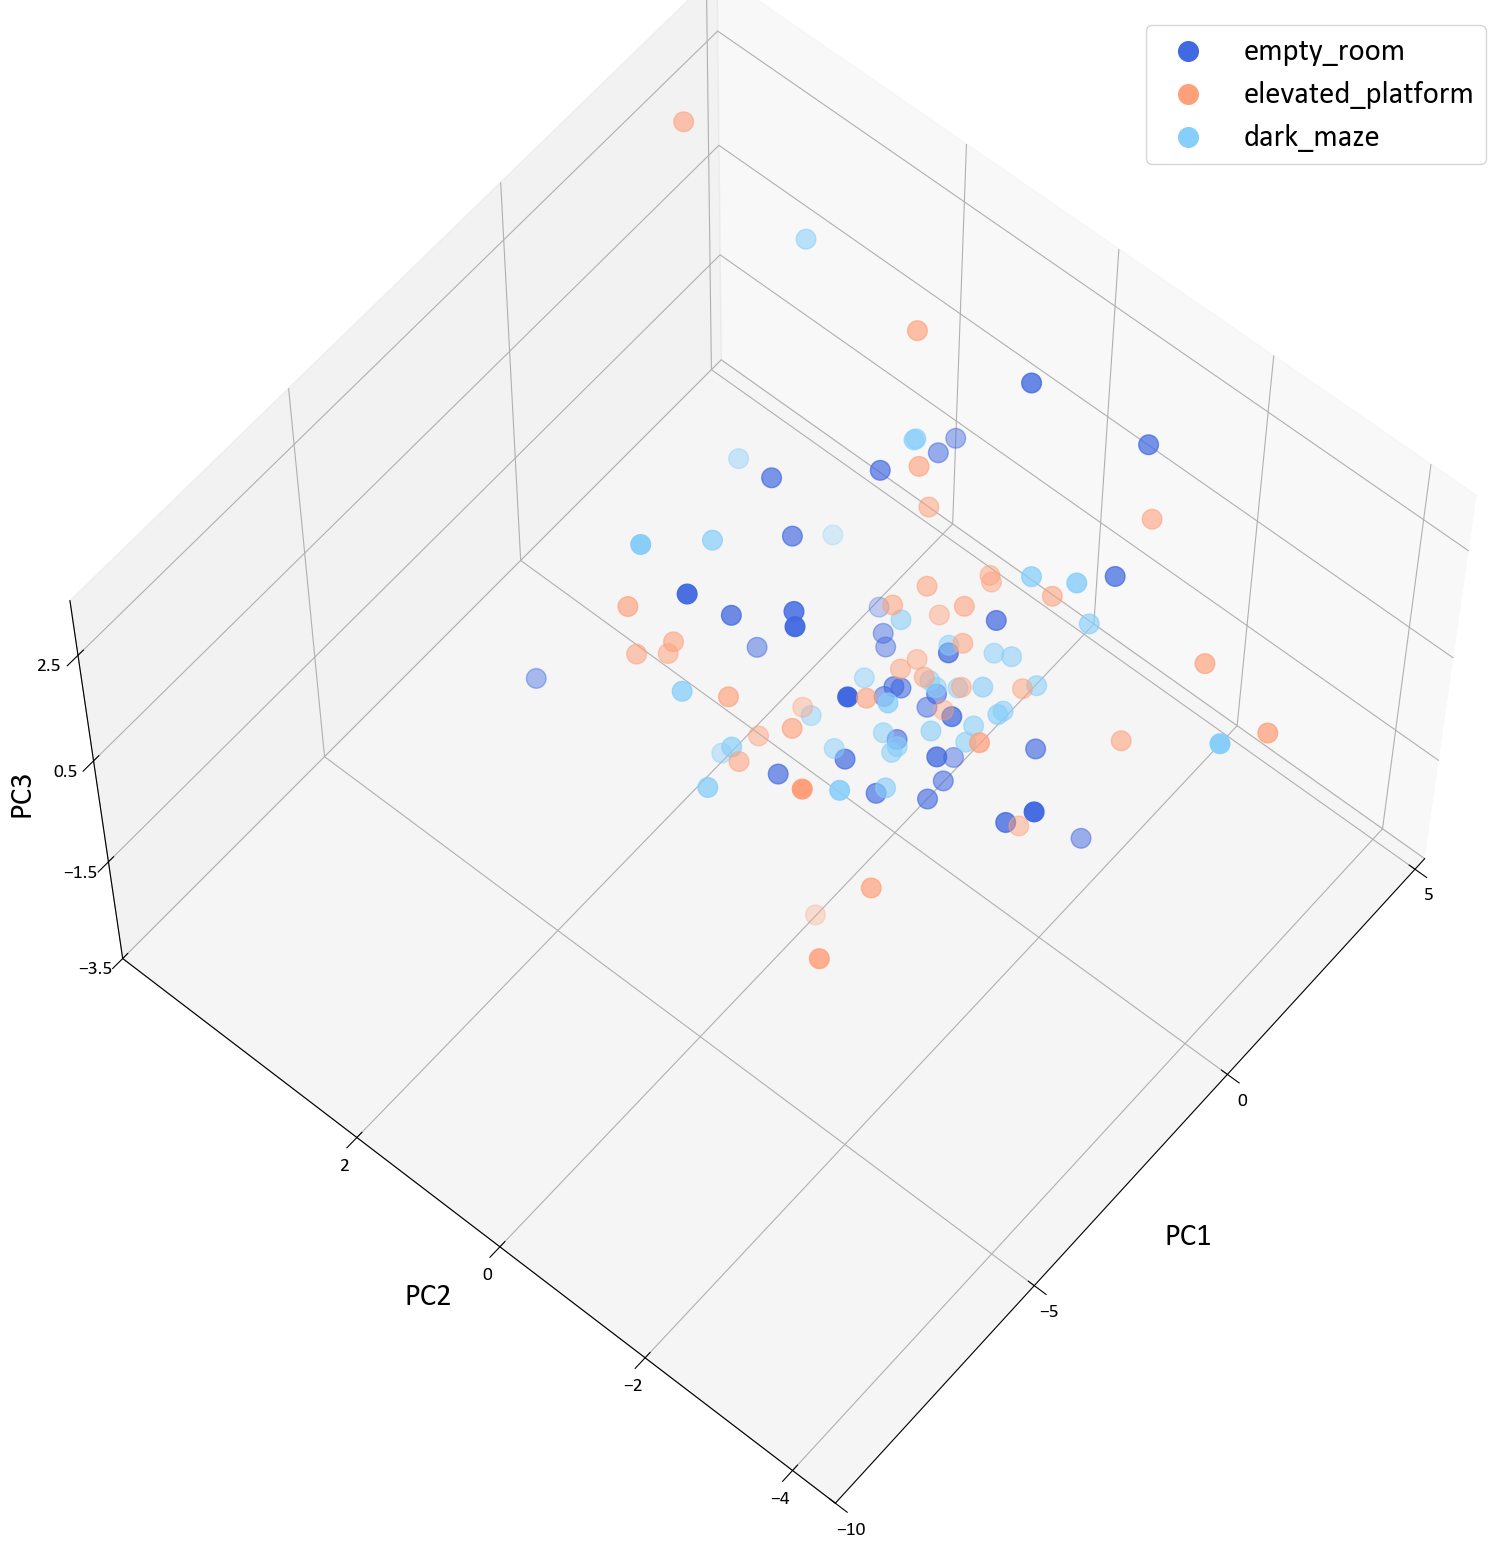

In [174]:
display_pc3d(df_combined)

In [ ]:
combined_30_empty_room['scene'] = 'Empty Room'
combined_30_elevated_platform['scene'] = 'Elevated Platform'
combined_30_dark_maze['scene'] = 'Dark Maze'

df_combined_30 = pd.concat([
    combined_30_empty_room,
    combined_30_elevated_platform,
    combined_30_dark_maze
], ignore_index=True)  

In [ ]:
display_pc3d(df_combined_30)

In [175]:
from tkinter import font


def display_pc_weights(components_weight, is_horizontal=False, save_fig=False):
    """
    Displays the weights (loadings) of all ratings on each principal component.
    
    Parameters:
    - components_weight: DataFrame of shape (ratings x PCs) or (PCs x ratings)
    - is_horizontal: if True, shows PCs on y-axis; if False, PCs on x-axis
    - save_fig: if True, saves the figure as 'pc_weights_plot.png'
    """

    import matplotlib.pyplot as plt
    import seaborn as sb

    if is_horizontal:
        # Horizontal: ratings on x, PCs on y
        display(components_weight)

        fig, axes = plt.subplots(figsize=(10, 4))
        sb.heatmap(components_weight, cmap='RdBu_r', ax=axes,
                   yticklabels=['PC1', 'PC2', 'PC3'],
                   annot=True, vmin=-1, vmax=1)

        axes.set_xlabel('Features', fontsize=14)
        axes.set_ylabel('Principal Component', fontsize=14)

    else:
        # Vertical: transpose → ratings on y, PCs on x
        components_weight = components_weight.transpose()
        display(components_weight)

        fig, axes = plt.subplots(figsize=(5, 8))
        sb.heatmap(components_weight, cmap='RdBu_r', ax=axes,
                   xticklabels=['PC1', 'PC2', 'PC3'],
                   annot=True, vmin=-1, vmax=1)

        axes.set_ylabel('Features')
        axes.set_xlabel('Principal Component')

    # Ticks style
    axes.tick_params(axis='x', labelrotation=60, labelsize=12)
    axes.tick_params(axis='y', labelrotation=0, labelsize=14)

    # Save figure if needed
    if save_fig:
        fig.savefig('pc_weights_plot.png', dpi=300)

    # Show plot
    plt.show(fig)
    plt.close(fig)


In [176]:
component_weight_90_empty_room = components_weight(df_90_pca_df, 3)

,center_dist,speed,acceleration,stops_duration,max_distance,area_covered,rmssd,hr
PC1,-0.126084,0.500750,0.359040,-0.385242,0.234081,0.471374,-0.271887,0.324223
PC2,0.630433,0.091669,0.157145,0.082623,0.561967,0.136754,0.422719,-0.222328
PC3,0.401168,-0.120841,0.288746,0.456512,0.017146,-0.238521,-0.431320,0.538016


In [177]:
component_weight_90_empty_room

,center_dist,speed,acceleration,stops_duration,max_distance,area_covered,rmssd,hr
PC1,-0.126084,0.500750,0.359040,-0.385242,0.234081,0.471374,-0.271887,0.324223
PC2,0.630433,0.091669,0.157145,0.082623,0.561967,0.136754,0.422719,-0.222328
PC3,0.401168,-0.120841,0.288746,0.456512,0.017146,-0.238521,-0.431320,0.538016


In [178]:
# Rename the columns with more descriptive names
component_weight_90_empty_room = component_weight_90_empty_room.rename(
    columns={
        'center_dist': 'Distance from Center',
        'speed': 'Movement Speed',
        'acceleration': 'Movement Acceleration',
        'stops_duration': 'Duration of Stops',
        'max_distance': 'Maximum Distance',
        'area_covered': 'Area Coverage',
        'rmssd': 'RMSSD',
        'hr': 'HR'
    }
)

,Distance from Center,Movement Speed,Movement Acceleration,Duration of Stops,Maximum Distance,Area Coverage,RMSSD,HR
PC1,-0.126084,0.500750,0.359040,-0.385242,0.234081,0.471374,-0.271887,0.324223
PC2,0.630433,0.091669,0.157145,0.082623,0.561967,0.136754,0.422719,-0.222328
PC3,0.401168,-0.120841,0.288746,0.456512,0.017146,-0.238521,-0.431320,0.538016


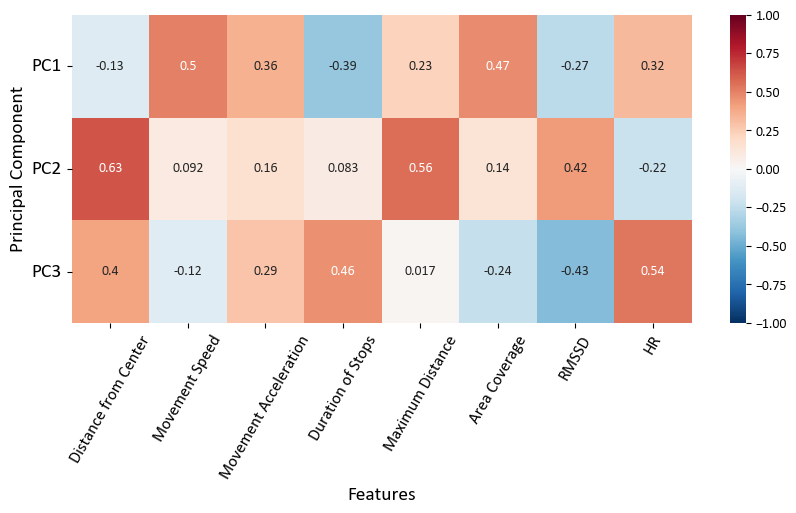

In [179]:
display_pc_weights(component_weight_90_empty_room, is_horizontal=True, save_fig=False)

In [180]:
component_weight_90_empty_room = components_weight(df_90_pca_empty_room_df, 3)

,center_dist,speed,acceleration,stops_duration,max_distance,area_covered,rmssd,hr
PC1,-0.126084,0.500750,0.359040,-0.385242,0.234081,0.471374,-0.271887,0.324223
PC2,0.630433,0.091669,0.157145,0.082623,0.561967,0.136754,0.422719,-0.222328
PC3,0.401168,-0.120841,0.288746,0.456512,0.017146,-0.238521,-0.431320,0.538016


,center_dist,speed,acceleration,stops_duration,max_distance,area_covered,rmssd,hr
PC1,-0.126084,0.500750,0.359040,-0.385242,0.234081,0.471374,-0.271887,0.324223
PC2,0.630433,0.091669,0.157145,0.082623,0.561967,0.136754,0.422719,-0.222328
PC3,0.401168,-0.120841,0.288746,0.456512,0.017146,-0.238521,-0.431320,0.538016


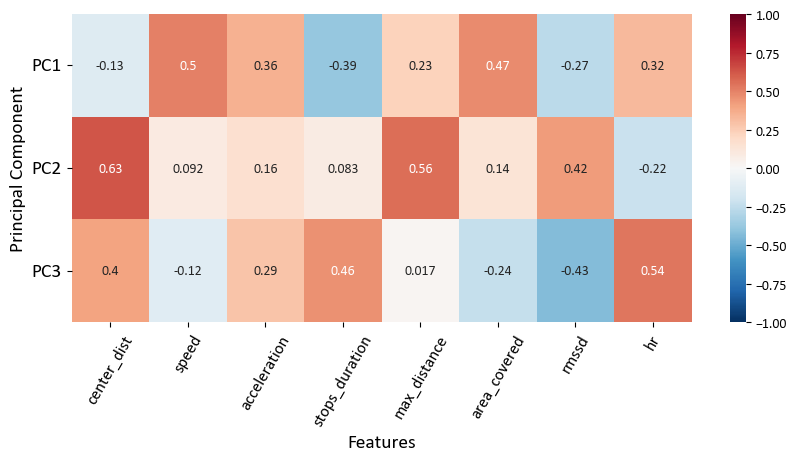

In [181]:
display_pc_weights(component_weight_90_empty_room, is_horizontal=True, save_fig=False)

,center_dist,speed,acceleration,stops_duration,max_distance,area_covered,rmssd,hr,safe_area_coverage,unsafe_area_coverage,safe_time_spent,unsafe_time_spent
PC1,0.350334,0.323422,0.148497,-0.286726,0.351555,0.276689,0.013498,-0.042166,-0.012467,0.395581,-0.393483,0.393478
PC2,-0.237886,0.375942,0.325499,-0.360570,0.182100,-0.227590,-0.065407,0.206945,0.580427,-0.001821,0.220409,-0.220401
PC3,0.054247,0.018750,0.222885,0.122481,-0.240930,0.211668,-0.627034,0.637851,-0.160965,0.047066,-0.022621,0.022667


,center_dist,speed,acceleration,stops_duration,max_distance,area_covered,rmssd,hr,safe_area_coverage,unsafe_area_coverage,safe_time_spent,unsafe_time_spent
PC1,0.350334,0.323422,0.148497,-0.286726,0.351555,0.276689,0.013498,-0.042166,-0.012467,0.395581,-0.393483,0.393478
PC2,-0.237886,0.375942,0.325499,-0.360570,0.182100,-0.227590,-0.065407,0.206945,0.580427,-0.001821,0.220409,-0.220401
PC3,0.054247,0.018750,0.222885,0.122481,-0.240930,0.211668,-0.627034,0.637851,-0.160965,0.047066,-0.022621,0.022667


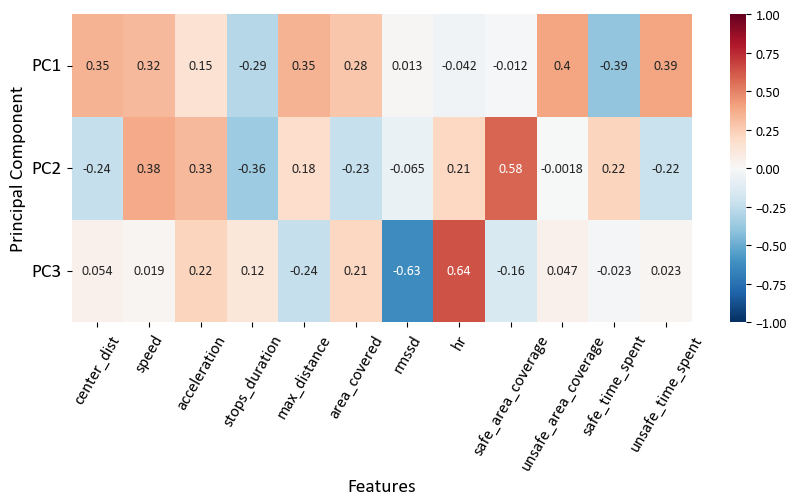

In [182]:
component_weight_90_elevated_platform = components_weight(df_90_pca_elevated_platform_df, 3)
display_pc_weights(component_weight_90_elevated_platform, is_horizontal=True, save_fig=False)

In [183]:
component_weight_90_elevated_platform 

,center_dist,speed,acceleration,stops_duration,max_distance,area_covered,rmssd,hr,safe_area_coverage,unsafe_area_coverage,safe_time_spent,unsafe_time_spent
PC1,0.350334,0.323422,0.148497,-0.286726,0.351555,0.276689,0.013498,-0.042166,-0.012467,0.395581,-0.393483,0.393478
PC2,-0.237886,0.375942,0.325499,-0.360570,0.182100,-0.227590,-0.065407,0.206945,0.580427,-0.001821,0.220409,-0.220401
PC3,0.054247,0.018750,0.222885,0.122481,-0.240930,0.211668,-0.627034,0.637851,-0.160965,0.047066,-0.022621,0.022667


In [184]:
def display_pc_weights(components_weight, is_horizontal=True, save_fig=False):
    """
    Displays the weights (loadings) of all ratings on each principal component.
    
    Parameters:
    - components_weight: DataFrame of shape (ratings x PCs) or (PCs x ratings)
    - is_horizontal: if True, shows PCs on y-axis; if False, PCs on x-axis
    - save_fig: if True, saves the figure as 'pc_weights_plot.png'
    
    Returns:
    - fig, axes
    """
    import matplotlib.pyplot as plt
    import seaborn as sb

    # Set Calibri font
    plt.rcParams['font.family'] = 'Calibri'

    if is_horizontal:
        # Horizontal: ratings on x, PCs on y
        display(components_weight)

        fig, axes = plt.subplots(figsize=(10, 4))
        sb.heatmap(components_weight, cmap='RdBu_r', ax=axes,
                   yticklabels=['PC1', 'PC2', 'PC3'],
                   annot=True, vmin=-1, vmax=1)

        axes.set_xlabel('Features', fontsize=14)
        axes.set_ylabel('Principal Component', fontsize=14)

    else:
        # Vertical: transpose → ratings on y, PCs on x
        components_weight = components_weight.transpose()
        display(components_weight)

        fig, axes = plt.subplots(figsize=(5, 8))
        sb.heatmap(components_weight, cmap='RdBu_r', ax=axes,
                   xticklabels=['PC1', 'PC2', 'PC3'],
                   annot=True, vmin=-1, vmax=1)

        axes.set_ylabel('Features')
        axes.set_xlabel('Principal Component')

    # Ticks style
    axes.tick_params(axis='x', labelrotation=60, labelsize=12)
    axes.tick_params(axis='y', labelrotation=0, labelsize=14)

    # Save figure if needed
    if save_fig:
        fig.savefig('pc_weights_plot.png', dpi=300)

    # Return fig and axes so user can modify after
    return fig, axes


,Distance from Center,Movement Speed,Movement Acceleration,Duration of Stops,Maximum Distance,Area Coverage,RMSSD,HR
PC1,-0.126084,0.500750,0.359040,-0.385242,0.234081,0.471374,-0.271887,0.324223
PC2,0.630433,0.091669,0.157145,0.082623,0.561967,0.136754,0.422719,-0.222328
PC3,0.401168,-0.120841,0.288746,0.456512,0.017146,-0.238521,-0.431320,0.538016


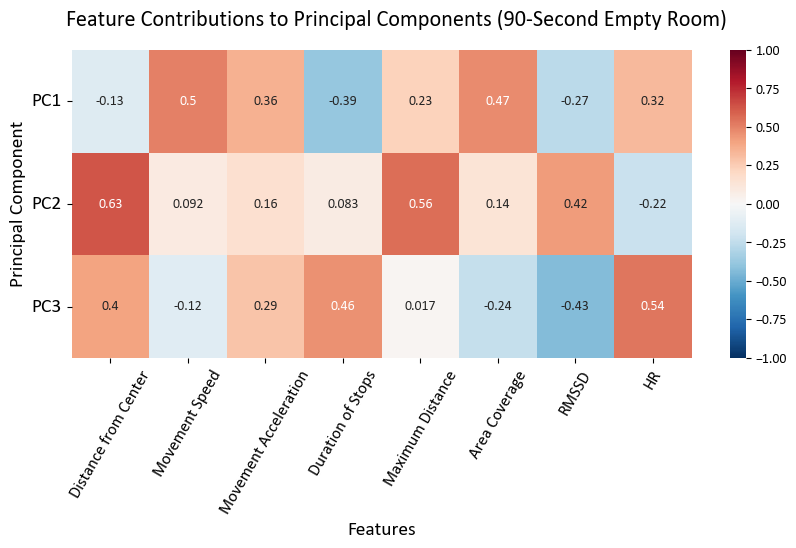

In [185]:
component_weight_90_empty_room = component_weight_90_empty_room.rename(
    columns={
        'center_dist': 'Distance from Center',
        'speed': 'Movement Speed',
        'acceleration': 'Movement Acceleration',
        'stops_duration': 'Duration of Stops',
        'max_distance': 'Maximum Distance',
        'area_covered': 'Area Coverage',
        'rmssd': 'RMSSD',
        'hr': 'HR'
    }
)
fig, ax = display_pc_weights(component_weight_90_empty_room)

# Add title now!
plt.suptitle("Feature Contributions to Principal Components (90-Second Empty Room)", fontsize=16, x=0.45)

plt.show()


In [186]:
component_weight_90_elevated_platform

,center_dist,speed,acceleration,stops_duration,max_distance,area_covered,rmssd,hr,safe_area_coverage,unsafe_area_coverage,safe_time_spent,unsafe_time_spent
PC1,0.350334,0.323422,0.148497,-0.286726,0.351555,0.276689,0.013498,-0.042166,-0.012467,0.395581,-0.393483,0.393478
PC2,-0.237886,0.375942,0.325499,-0.360570,0.182100,-0.227590,-0.065407,0.206945,0.580427,-0.001821,0.220409,-0.220401
PC3,0.054247,0.018750,0.222885,0.122481,-0.240930,0.211668,-0.627034,0.637851,-0.160965,0.047066,-0.022621,0.022667


,Distance from Center,Movement Speed,Movement Acceleration,Duration of Stops,Maximum Distance,Area Coverage,RMSSD,HR,Safe Area Coverage,Unsafe Area Coverage,Safe Time Spent,Unsafe Time Spent
PC1,0.350334,0.323422,0.148497,-0.286726,0.351555,0.276689,0.013498,-0.042166,-0.012467,0.395581,-0.393483,0.393478
PC2,-0.237886,0.375942,0.325499,-0.360570,0.182100,-0.227590,-0.065407,0.206945,0.580427,-0.001821,0.220409,-0.220401
PC3,0.054247,0.018750,0.222885,0.122481,-0.240930,0.211668,-0.627034,0.637851,-0.160965,0.047066,-0.022621,0.022667


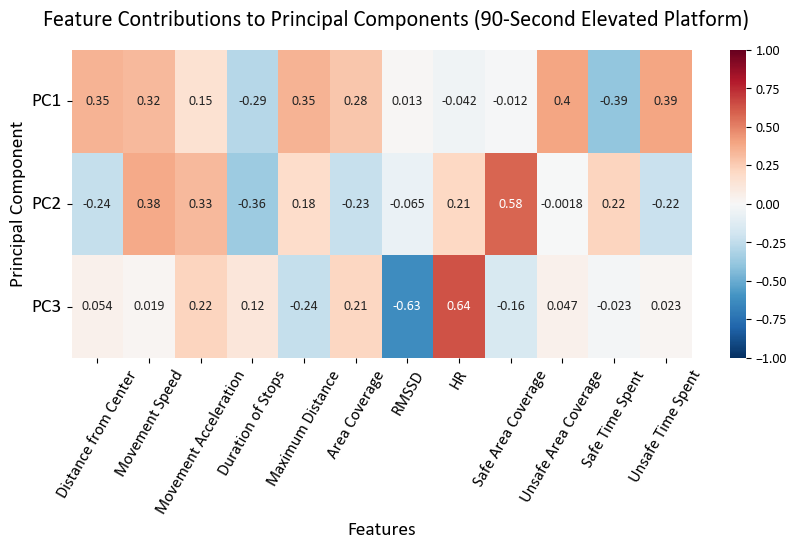

In [187]:
component_weight_90_elevated_platform = component_weight_90_elevated_platform.rename(
    columns={
        'center_dist': 'Distance from Center',
        'speed': 'Movement Speed',
        'acceleration': 'Movement Acceleration',
        'stops_duration': 'Duration of Stops',
        'max_distance': 'Maximum Distance',
        'area_covered': 'Area Coverage',
        'rmssd': 'RMSSD',
        'hr': 'HR',
        'safe_area_coverage': 'Safe Area Coverage',
        'unsafe_area_coverage': 'Unsafe Area Coverage',
        'safe_time_spent': 'Safe Time Spent',
        'unsafe_time_spent': 'Unsafe Time Spent'
    }
)
fig, ax = display_pc_weights(component_weight_90_elevated_platform)

# Add title now!
plt.suptitle("Feature Contributions to Principal Components (90-Second Elevated Platform)", fontsize=16, x=0.45)

plt.show()

,speed,acceleration,stops_duration,max_distance,area_covered,rmssd,hr
PC1,0.509683,0.218294,-0.500191,0.402481,0.524224,-0.047835,0.057357
PC2,0.014389,0.397714,0.024259,-0.204102,-0.125759,-0.594444,0.655889
PC3,0.226571,0.651015,-0.146047,-0.482582,-0.199976,0.445677,-0.178918


,Movement Speed,Movement Acceleration,Duration of Stops,Maximum Distance,Area Coverage,RMSSD,HR
PC1,0.509683,0.218294,-0.500191,0.402481,0.524224,-0.047835,0.057357
PC2,0.014389,0.397714,0.024259,-0.204102,-0.125759,-0.594444,0.655889
PC3,0.226571,0.651015,-0.146047,-0.482582,-0.199976,0.445677,-0.178918


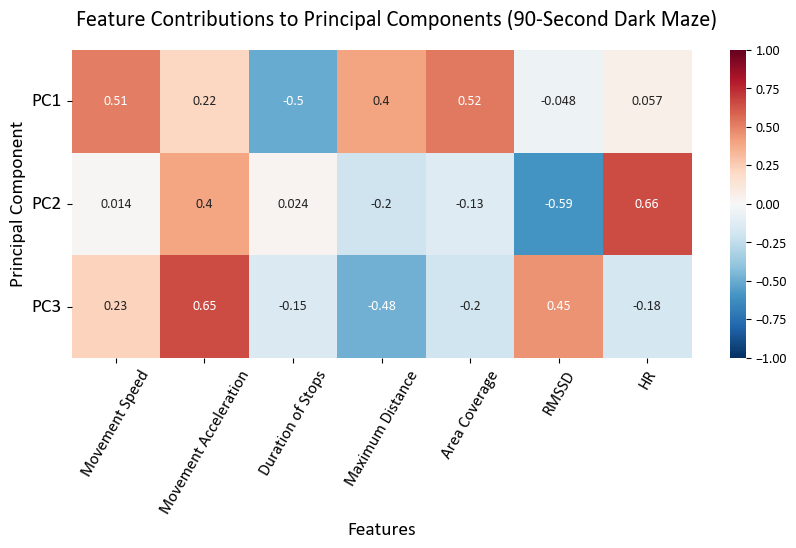

In [188]:
component_weight_90_dark_maze = components_weight(df_90_pca_dark_maze_df, 3)
component_weight_90_dark_maze = component_weight_90_dark_maze.rename(
    columns={
        'speed': 'Movement Speed',
        'acceleration': 'Movement Acceleration',
        'stops_duration': 'Duration of Stops',
        'max_distance': 'Maximum Distance',
        'area_covered': 'Area Coverage',
        'rmssd': 'RMSSD',
        'hr': 'HR',
    }
)
fig, ax = display_pc_weights(component_weight_90_dark_maze)

# Add title now!
plt.suptitle("Feature Contributions to Principal Components (90-Second Dark Maze)", fontsize=16, x=0.45)

plt.show()